# Robust Lookup Table: Coordinates prediction

The goal of this notebook is to predict the coordinates of the backends in the output lookup table.

## TODO

- [ ] Add noise to the input
- [ ] Add dropout
- [ ] Add regularization

In [1]:
import os
import math
import datetime
import time
import uuid
import random
import hashlib

import torch
from torch import nn

import numpy as np
from matplotlib import pyplot as plt

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [177]:
# Hyper parameters
learning_rate = 1e-3
epochs = 200
batch_size = 32

# Experiment parameters
# -- n_max: the maximum number of backends.
n_max = 5
# -- m: the size of the lookup table.
m = 15
# -- o: the number of axis for the coordinates.
o = 2
# scenario variables:
nBeforeBounds = (3, n_max)
nAfterBounds = (1, n_max)
variance = (1.0, 10)

In [4]:
# Config
# - nBeforeBounds(x, y): nBefore ∈ [x, y].
# - nAfterBounds(x, y): nAfter ∈ [x, y].
# - variance(x, y): x < min(nBefore,nAfter)/max(nBefore,nAfter); y < max(nBefore,nAfter) - min(nBefore,nAfter)
# - m: the fixed size of the lookup table.
# - o: the number of axis for coordinates.
class Config:
    n_max: int
    m: int
    o: int
    nBeforeBounds: (int, int)
    nAfterBounds: (int, int)
    variance: (float, int)

    def __init__(
        self,
        n_max: int,
        m: int,
        o: int,
        nBeforeBounds: (int, int),
        nAfterBounds: (int, int),
        variance: (float, int),
        # sizeBounds: (int, int),
    ):
        if nBeforeBounds[1] > m or nAfterBounds[1] > m:
            raise Exception("nBeforeBounds and nAfterBounds cannot exceed size")

        self.n_max = n_max
        self.m = m
        self.o = o
        self.nBeforeBounds = nBeforeBounds
        self.nAfterBounds = nAfterBounds
        self.variance = variance

Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance).__dict__

{'n_max': 5,
 'm': 15,
 'o': 2,
 'nBeforeBounds': (3, 5),
 'nAfterBounds': (1, 5),
 'variance': (1.0, 10)}

In [5]:
# m: the size of the lookup table.
# o: the number of axis for the coordinates.
# the function returns the backend coordinates of size (o,)
def NewBackendCoordinates(m: int, o: int):
    id = uuid.uuid4()
    _h = hashlib.sha256()
    _h.update(id.bytes_le)
    hash_bytes = _h.digest()

    coord = []
    hash_length = 32
    slice = int(hash_length/o)

    for i in range(o):
        start = i*slice
        end = (i+1)*slice
        if start >= hash_length:
            continue
        if end > hash_length:
            end = hash_length
        hmod = int.from_bytes(hash_bytes[start:end], "little") % m
        coord.append(hmod)

    if len(coord) < o:
        raise Exception(f"Cannot create new backend tensor! please decrease `o`: got {o}")

    return coord

NewBackendCoordinates(m, o)

[11, 4]

In [83]:
class Scenario:
    nBefore: int
    nAfter: int
    m: int
    o: int

    def __init__(
        self,
        cfg: Config,
    ):
        self.cfg = cfg
        self.nBefore = random.randint(cfg.nBeforeBounds[0], cfg.nBeforeBounds[1])
        self.nAfter = random.randint(cfg.nAfterBounds[0], cfg.nAfterBounds[1])

    def GenerateBackends(self):
        l_min = []
        l_max = []
        _min = min([self.nBefore, self.nAfter])
        _max = max([self.nBefore, self.nAfter])
        # create the l_max backend array.
        l_max = np.array([ NewBackendCoordinates(self.cfg.m, self.cfg.o) for _ in range(_max) ])
        # create l_min array by randomly choosing _min elements of l_max.
        l_min = np.random.permutation(l_max)[0:_min]
        # pad
        l_max = [l_max[i] if i < _max else [-1, -1] for i in range(self.cfg.n_max) ]
        l_min = [l_min[i] if i < _min else [-1, -1] for i in range(self.cfg.n_max) ]
        # they used to be sorted but we don't need to anymore.
        if self.nBefore < self.nAfter:
            return (l_min, l_max)
        return (l_max, l_min)

def validate_scenario(cfg: Config, scenario: Scenario) -> bool:
    var = cfg.variance[0]
    delta = cfg.variance[1]

    _min = min([scenario.nBefore, scenario.nAfter])
    _max = max([scenario.nBefore, scenario.nAfter])
    _var = _min/_max
    _delta = _max - _min
    _sz = scenario.cfg.m

    return _var <= var and _delta <= delta and _max <= _sz and _min != _max

# creates a new scenario generator.
def NewScenarioGenerator(cfg):
    while True:
        scenario = Scenario(cfg)
        if validate_scenario(cfg, scenario):
            yield scenario

cfg = Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance)
scgen = next(NewScenarioGenerator(cfg))
print(scgen.__dict__)
bef, aft = scgen.GenerateBackends()
print("before:\n", bef)
print("after:\n", aft)

{'cfg': <__main__.Config object at 0x7885dddfe630>, 'nBefore': 4, 'nAfter': 2}
before:
 [array([14, 10]), array([10, 13]), array([1, 0]), array([11, 11]), [-1, -1]]
after:
 [array([14, 10]), array([10, 13]), [-1, -1], [-1, -1], [-1, -1]]


In [231]:
# NewBatchGenerator yields a tuple of 2 batch of size batch_size.
def NewBatchGenerator(batch_size: int, scenario_generator):
    while True:
        before = []
        after = []
        for _ in range(batch_size):
            b, a = next(scenario_generator).GenerateBackends()
            before.append(b)
            after.append(a)
        yield (
            torch.tensor(np.array(before), dtype=torch.float32, requires_grad=False),
            torch.tensor(np.array(after), dtype=torch.float32, requires_grad=False),
        )

cfg = Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance)
scenario_generator = NewScenarioGenerator(cfg)
bef, aft = next(NewBatchGenerator(batch_size, scenario_generator))
print(bef[0][0])
print(f"tensor size must be: [{batch_size}, {cfg.n_max}, {cfg.o}]")
bef.size(), aft.size()

tensor([14.,  2.])
tensor size must be: [32, 5, 2]


(torch.Size([32, 5, 2]), torch.Size([32, 5, 2]))

## Loss functions

- Stability: measures how well the model predicts a lookup table that matches as much as possible entries from the "before" state.
- Accuracy: measures how precisely the model predicts coordinates. The precision is measured by calculating distance from input and output coordinates.
- Distribution: measures how evenly the model distributes coordinates into the lookup table.

In [90]:
# -- Stability loss experiment
bef = torch.Tensor((
    [
        [5, 5], [0, 0], [1, 1], [1, 1],
    ],[
        [0, 0], [0, 0], [1, 1], [1, 1],
    ]
))
bef.requires_grad_() # to check if the loss func stays differentiable.
print("size: [batch_size=2, m=4, o=2]:\n", a.size())

aft = torch.Tensor((
    [
        [0, 0], [0, 0], [1, 1], [1, 1],
    ],[
        [0, 0], [0, 0], [1, 1], [1, 1],
    ]
))

d = nn.PairwiseDistance(p=2)(bef, aft)
print("---\npairwise distance:\n", d, "\nsize:\n", d.size())
d = torch.nn.Tanh()(d)
print("---\ntanh:\n", d)
print("---\nmean:\n", torch.mean(d))

size: [batch_size=2, m=4, o=2]:
 torch.Size([2, 4, 2])
---
pairwise distance:
 tensor([[7.0711e+00, 1.4142e-06, 1.4142e-06, 1.4142e-06],
        [1.4142e-06, 1.4142e-06, 1.4142e-06, 1.4142e-06]],
       grad_fn=<NormBackward1>) 
size:
 torch.Size([2, 4])
---
tanh:
 tensor([[1.0000e+00, 1.4142e-06, 1.4142e-06, 1.4142e-06],
        [1.4142e-06, 1.4142e-06, 1.4142e-06, 1.4142e-06]],
       grad_fn=<TanhBackward0>)
---
mean:
 tensor(0.1250, grad_fn=<MeanBackward0>)


In [263]:
# -- stabLoss = (mean_distance / (1-max_distance))
class StabilityLoss(nn.Module):
    def __init__(self):
        super(StabilityLoss, self).__init__()

    def forward(
        self,
        # -- will help compute the baseline.
        before_in: torch.Tensor,
        after_in: torch.tensor,
        # -- will help compute the distance.
        before_out: torch.Tensor,
        after_out: torch.Tensor,
    ):
        n_max = before_in.size(dim=1)
        nil_coord = torch.tensor([-1,-1])
    
        # get n for each row in batch. 
        # for each row we sum "nil" coordinates, i.e. all occurences of [-1,-1].
        before_len = n_max - torch.where(before_in == nil_coord, 1, 0).sum(dim=1)[:, 0]
        after_len = n_max - torch.where(after_in == nil_coord, 1, 0).sum(dim=1)[:, 0]
    
        # we calculate the maximum theoritical unchanged entry rate b/w before and after.
        # -- max_th=max(before_len, after_len)/min(before_len, after_len)
        _min = torch.where(before_len < after_len, before_len, after_len)
        _max = torch.where(before_len > after_len, before_len, after_len)
        max_th = _min/_max
    
        # -- compute distance b/w before_out & after_out.
        d = torch.nn.PairwiseDistance(p=2)(before_out, after_out)
        d_tanh = torch.nn.Tanh()(d)
        
        # stability: it accounts for maximum theoretical rate.
        # stab = computed_d/(1-max_th)
        stab = d_tanh / max_th.reshape((max_th.size(dim=0),1,1))
    
        # we return the mean over all elements of the batch.
        return torch.mean(stab)
    
bef = torch.Tensor((
    [
        [0, 0], [0, 0], [1, 1], [1, 1],
    ],[
        [0, 0], [0, 0], [1, 1], [1, 1],
    ]
))
bef.requires_grad_() # to check if the loss func stays differentiable.

aft = torch.Tensor((
    [
        [0, 0], [0, 0], [1, 1], [1, 1],
    ],[
        [2, 2], [0, 0], [2, 2], [1, 1],
    ]
))

before_in = torch.tensor([
    [[0, 1], [2, 3], [0, 0]],
    [[0, 1], [-1, -1], [0, 0]],
]) 

after_in = torch.tensor([
    [[0, 1], [2, 3], [0, 0]],
    [[0, 1], [-1, -1], [-1,-1]],
]) 

StabilityLoss()(before_in, after_in, bef, aft)

tensor(0.3528, grad_fn=<MeanBackward0>)

## Model

In [256]:
class NN(nn.Module):
    n_max: int
    m: int
    o: int

    flatten: nn.Flatten
    seq: nn.Sequential

    def __init__(
        self,
        n_max: int,
        m: int,
        o: int,
        hl_size=512, # hidden layer size
    ):
        super().__init__()
        self.n_max = n_max
        self.m = m
        self.o = o

        in_size = n_max*o
        out_size = m*o
        
        self.flatten = nn.Flatten(start_dim=1)
        self.seq = nn.Sequential(
            nn.Linear(in_size, hl_size),
            nn.ReLU(),
            nn.Linear(hl_size, hl_size),
            nn.ReLU(),
            nn.Linear(hl_size, out_size),
            nn.ReLU(),
        )

    # takes an input of size:    [batch_size, n_max, o]
    # returns an output of size: [batch_size, m, o]
    def forward(self, x):
        x = self.flatten(x)
        x = nn.functional.normalize(x, dim=1) # normalize in.
        x = self.seq(x)
        x = nn.functional.normalize(x, dim=1) # normalize out.
        return x.view(-1, self.m, self.o) # make it 2-dimensional array.

cfg = Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance)
scenario_generator = NewScenarioGenerator(cfg)
bef, _ = next(NewBatchGenerator(batch_size, scenario_generator))
model = NN(cfg.n_max, cfg.m, cfg.o, hl_size=32).to(device)
model(bef).size()

torch.Size([32, 15, 2])

## Training

model has 2398 parameters
training model...
epoch 1/100: loss=0.07731989026069641, elapsed_time=0:00:00.004869
epoch 11/100: loss=0.04248279333114624, elapsed_time=0:00:00.045657
epoch 21/100: loss=0.022544212639331818, elapsed_time=0:00:00.078439
epoch 31/100: loss=0.018874002620577812, elapsed_time=0:00:00.108741
epoch 41/100: loss=0.014061198569834232, elapsed_time=0:00:00.137073
epoch 51/100: loss=0.010229617357254028, elapsed_time=0:00:00.164773
epoch 61/100: loss=0.010207011364400387, elapsed_time=0:00:00.193127
epoch 71/100: loss=0.0077340020798146725, elapsed_time=0:00:00.225911
epoch 81/100: loss=0.007339867297559977, elapsed_time=0:00:00.259176
epoch 91/100: loss=0.005246765911579132, elapsed_time=0:00:00.291135
epoch 100/100: loss=0.004814945627003908, elapsed_time=0:00:00.318528
b_out:
 tensor([[0.3408, 0.1310],
        [0.3089, 0.1512],
        [0.4460, 0.0000],
        [0.0000, 0.1152],
        [0.0000, 0.2567],
        [0.2052, 0.2972],
        [0.0000, 0.0000],
        

<function matplotlib.pyplot.show(close=None, block=None)>

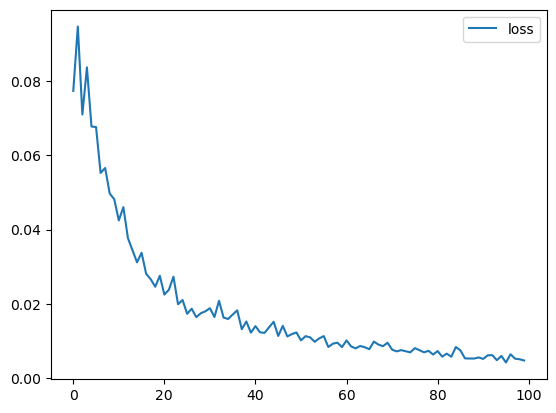

In [264]:
# Hyper parameters
learning_rate = 1e-3
epochs = 100
batch_size = 32

# Experiment parameters
# -- n_max: the maximum number of backends.
n_max = 5
# -- m: the size of the lookup table.
m = 15
# -- o: the number of axis for the coordinates.
o = 2
# -- scenario variables
nBeforeBounds = (3, n_max)
nAfterBounds = (1, n_max)
variance = (1.0, 10)
# -- hl_size: hidden layer size.
hl_size=32

cfg = Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance)
scgen = NewScenarioGenerator(cfg)
batchgen = NewBatchGenerator(batch_size, scgen)

model = NN(cfg.n_max, cfg.m, cfg.o, hl_size=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = StabilityLoss()

total_params = sum(p.numel() for p in model.parameters())
print(f"model has {total_params} parameters")

start_time = time.time()
print("training model...")
loss_history = []
for epoch in range(epochs):
    # -- reset optimizer
    optimizer.zero_grad()

    # -- generate inputs
    b_in, a_in = next(batchgen)
    # -- run model
    b_out = model(b_in)
    a_out = model(a_in)
    # -- compute loss
    loss = loss_fn(b_in, a_in, b_out, a_out)
    loss.backward()
    # -- step
    optimizer.step()

    # -- display loss 
    detached_loss = loss.detach().numpy()
    loss_history.append(detached_loss)
    if epoch % 10 != 0 and epoch != epochs - 1:
        continue
    elapsed = datetime.timedelta(seconds=(time.time() - start_time))
    print(f"epoch {epoch+1}/{epochs}: loss={loss}, elapsed_time={elapsed}")

    if epoch == epochs - 1:
        print("b_out:\n", b_out[0])
        print("a_out:\n", a_out[0])

    # for name, param in model.named_parameters():
    #     if name == "seq.4.bias":
    #         print(f"Parameter name: {name}, data_sample: {param.data[0]}")

plt.plot(loss_history, label='loss')
plt.legend()
plt.show